# **Predictive Default Risk Assessor V.01**

# TODO

* Base model 
* Comparison
* Specialised
* For small entities - Examples?
* Backtest - All sectors 
* Understanding the model across all sectors/industries
* Any markets - consumer goods, industries
* UI last step after backtesting

In [388]:
model_inputs = {
    "profitability": {
        "class_weight": 0.30,
        "weights": [1.0], 
        "metrics": {
            "oper_margin": {
                "lower_is_better": False,
                "thresholds": [
                    (40, float("inf")),
                    (35, 39),
                    (30, 34),
                    (25, 29),
                    (20, 24),
                    (15, 19),
                    (10, 14),
                    (5, 9),
                    (float("-inf"), 0)
                ],
            }
        },
    },
    "leverage_coverage": {
        "class_weight": 0.55,
        "weights": [0.4, 0.3, 0.3],
        "metrics": {
            "tot_debt_to_tot_eqy": {
                "lower_is_better": True,
                "thresholds": [
                     (float("-inf"), 2.0),
                     (2.0, 16.0),
                     (16.0, 24.0),
                     (24.0, 33.0),
                     (33.0, 43.0),
                     (43.0, 54.0),
                     (54.0, 68.0),
                     (68.0, 94.0),
                     (94.0, float("inf")),
                ],
            },
            "tot_debt_to_ebitda": {
                "lower_is_better": True,
                "thresholds": [
                    (float("-inf"), 0.09),
                    (0.09, 0.49),
                    (0.49, 0.9),
                    (0.9, 1.36),
                    (1.36, 1.68),
                    (1.68, 2.26),
                    (2.26, 3.27),
                    (3.27, 4.4),
                    (4.4, float("inf")),
                ],
            },
            "ebitda_to_tot_int_exp": {
                "lower_is_better": False,
                "thresholds": [
                    (25, float("inf")),
                    (20, 25),
                    (15, 20),
                    (10, 15),
                    (5, 10),
                    (3, 5),
                    (1, 3),
                    (0, 1),
                    (float("-inf"), 0),
                ],
            },
        },
    },
    "efficiency": {
        "class_weight": 0.15,
        "weights": [0.5, 0.5],
        "metrics": {
            "return_on_asset": {
                "lower_is_better": False,
                "thresholds": [
                    (0.15, float("inf")),
                    (0.10, 0.15),
                    (0.08, 0.10),
                    (0.06, 0.08),
                    (0.04, 0.06),
                    (0.02, 0.04),
                    (0.00, 0.02),
                    (-0.02, 0.00),
                    (float("-inf"), -0.02)
                ],
            },
            "asset_turnover": {
                "lower_is_better": False,
                "thresholds": [
                    (4.0, float("inf")),
                    (3.0, 4.0),
                    (2.0, 3.0),
                    (1.5, 2.0),
                    (1.0, 1.5),
                    (0.75, 1.0),
                    (0.5, 0.75),
                    (0.25, 0.5),
                    (float("-inf"), 0.25)
                ],
            },
        },
    },
}

In [2]:
import pandas as pd
import numpy as np

In [389]:
class CreditRatingCalculator:
    def __init__(self, metrics):
        self.metrics = metrics
        
    def _calculate_metric_score(self, metric, thresholds, inverse):
        for score, (lower, upper) in enumerate(thresholds, start=1):
            if (inverse and metric <= upper) or (not inverse and metric >= lower):
                return score
        return len(thresholds) // 2 # else return the middle score

    def _calculate_category_score(self, category_metrics, ratios):
        total_weighted_score = 0

        for metric, weight in zip(
            category_metrics["metrics"].items(), category_metrics["weights"]
        ):
            metric_name, metric_data = metric
            value = ratios[metric_name]
            score = self._calculate_metric_score(
                value, metric_data["thresholds"], metric_data["lower_is_better"]
            )
            total_weighted_score += score * weight

        return total_weighted_score

    def _calculate_scores(self, ratios):
        scores = {}
        for category, category_data in self.metrics.items():
            category_score = self._calculate_category_score(category_data, ratios)
            scores[category] = category_score
        return scores

    def _calculate_weighted_score(self, scores):
        weights = {
            category: category_data["class_weight"]
            for category, category_data in self.metrics.items()
        }
        return sum(scores[category] * weight for category, weight in weights.items())

    def _determine_credit_rating(self, weighted_score):
        credit_ratings = [
            (2.5, "Aaa"),
            (3.5, "Aa"),
            (4.5, "A"),
            (5.5, "Baa"),
            (6.5, "Ba"),
            (7.5, "B"),
            (8.5, "Caa"),
            (9.5, "Ca"),
            (10, "C"),
        ]
    
        for threshold, rating in credit_ratings:
            if weighted_score < threshold:
                return rating

    def calculate_credit_rating(self, ratios):
        self.scores = self._calculate_scores(ratios)
        self.credit_score = self._calculate_weighted_score(self.scores)
        self.credit_rating = self._determine_credit_rating(self.credit_score)

In [390]:
features = pd.read_excel("dataset/features.xlsx", index_col=0)
targets = pd.read_excel("dataset/target.xlsx", index_col=0)
features.columns = features.columns.str.lower()

In [391]:
model_metrics = [
    "oper_margin", 
    "tot_debt_to_tot_eqy", 
    "tot_debt_to_ebitda", 
    "ebitda_to_tot_int_exp", 
    "return_on_asset",
    "asset_turnover",
]

ratios = features.loc[company][model_metrics].to_dict()

In [392]:
ratios

{'oper_margin': 4.372,
 'tot_debt_to_tot_eqy': 98.646,
 'tot_debt_to_ebitda': 2.0211,
 'ebitda_to_tot_int_exp': 5.5277,
 'return_on_asset': 11.2683,
 'asset_turnover': 3.8526}

In [393]:
model = CreditRatingCalculator(model_inputs)
model.calculate_credit_rating(ratios)
print(f"Model Inputs:")
display(ratios)
print("")
print(f"Class Scoring: {model.scores}")
print(f"Credit Score: {model.credit_score}")
print(f"Credit Rating: {model.credit_rating}")

Model Inputs:


{'oper_margin': 4.372,
 'tot_debt_to_tot_eqy': 98.646,
 'tot_debt_to_ebitda': 2.0211,
 'ebitda_to_tot_int_exp': 5.5277,
 'return_on_asset': 11.2683,
 'asset_turnover': 3.8526}


Class Scoring: {'profitability': 9.0, 'leverage_coverage': 6.9, 'efficiency': 1.5}
Credit Score: 6.72
Credit Rating: B


In [395]:
study = {}
ra = {}
for company in features.index:
    ratios = features.loc[company][model_metrics].to_dict()
    model = CreditRatingCalculator(model_inputs)
    model.calculate_credit_rating(ratios)
    ra[company] = ratios
    study[company] = {"class_scoreing": model.scores, "credit_score": model.credit_score, "credit_rating": model.credit_rating}
    
study = pd.DataFrame(study).T

In [396]:
study

,class_scoreing,credit_score,credit_rating
AGL SJ Equity,"{'profitability': 7.0, 'leverage_coverage': 6....",6.24,Ba
ANG SJ Equity,"{'profitability': 9.0, 'leverage_coverage': 6....",7.255,B
ANH SJ Equity,"{'profitability': 5.0, 'leverage_coverage': 7....",6.245,Ba
BAW SJ Equity,"{'profitability': 8.0, 'leverage_coverage': 6....",6.665,B
BHG SJ Equity,"{'profitability': 1.0, 'leverage_coverage': 3....",3.045,Aa
...,...,...,...
UGPA3 BS Equity,"{'profitability': 9.0, 'leverage_coverage': 7....",7.05,B
USIM5 BS Equity,"{'profitability': 9.0, 'leverage_coverage': 5....",6.435,Ba
VALE3 BS Equity,"{'profitability': 3.0, 'leverage_coverage': 4....",3.83,A
VAMO3 BS Equity,"{'profitability': 3.0, 'leverage_coverage': 8....",6.03,Ba


In [397]:
y.head()

,numeric_rating
AGL SJ Equity,5.5
ANG SJ Equity,5.5
ANH SJ Equity,4.5
BAW SJ Equity,6.5
BHG SJ Equity,4.5


In [398]:
ms = ['AGL SJ Equity', 'ANG SJ Equity', 'ANH SJ Equity', 'BAW SJ Equity',
'BHG SJ Equity', 'BVT SJ Equity', 'GFI SJ Equity', 'MNP SJ Equity',
'SAP SJ Equity', 'SOL SJ Equity', 'TKG SJ Equity', 'ABEV3 BS Equity',
'AZUL4 BS Equity', 'B3SA3 BS Equity', 'BEEF3 BS Equity',
'BPAC11 BS Equity', 'BRFS3 BS Equity', 'BRKM5 BS Equity',
'CIEL3 BS Equity', 'CMIG4 BS Equity', 'CSAN3 BS Equity',
'CSNA3 BS Equity', 'ELET3 BS Equity', 'ELET6 BS Equity',
'EMBR3 BS Equity', 'ENGI11 BS Equity', 'GGBR4 BS Equity',
'HYPE3 BS Equity', 'JBSS3 BS Equity', 'KLBN11 BS Equity',
'MOVI3 BS Equity', 'MRFG3 BS Equity', 'NTCO3 BS Equity',
'PETR3 BS Equity', 'PETR4 BS Equity', 'PRIO3 BS Equity',
'RAIL3 BS Equity', 'RAIZ4 BS Equity', 'RDOR3 BS Equity',
'RENT3 BS Equity', 'RRRP3 BS Equity', 'SBSP3 BS Equity',
'SMTO3 BS Equity', 'SUZB3 BS Equity', 'UGPA3 BS Equity',
'USIM5 BS Equity', 'VALE3 BS Equity', 'VAMO3 BS Equity',
'VBBR3 BS Equity']

In [399]:
import pandas as pd

In [400]:
ta = pd.read_excel('t.xlsx', index_col=0)

In [465]:
y = ta.copy()
X = pd.DataFrame(ra).T.fillna(0).loc[y_true.index]#.values

In [402]:
X.head()

,oper_margin,tot_debt_to_tot_eqy,tot_debt_to_ebitda,ebitda_to_tot_int_exp,return_on_asset,asset_turnover
AGL SJ Equity,12.7365,53.4902,2.5667,3.4697,0.4225,0.4577
ANG SJ Equity,0.8730,64.4385,1.8845,9.6807,-2.8928,0.5640
ANH SJ Equity,23.5197,84.3433,4.0381,4.9105,2.4711,0.2747
BAW SJ Equity,9.9294,70.4382,1.7885,4.1374,4.3344,0.8784
BHG SJ Equity,41.5073,46.0437,0.8155,24.3114,13.1537,0.5479


In [445]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [447]:
model = DecisionTreeRegressor(
    max_depth=4,
    min_weight_fraction_leaf=0.1,
)
model.fit(X, y)

DecisionTreeRegressor(max_depth=4, min_weight_fraction_leaf=0.1)

In [454]:
model.score(X, y)

0.5447136089577951

In [456]:
model.predict(X)

array([5.75      , 5.75      , 5.75      , 6.5       , 5.3       ,
       6.1       , 5.3       , 5.75      , 6.5       , 6.38888889,
       5.75      , 5.3       , 7.1       , 6.5       , 6.38888889,
       6.5       , 6.38888889, 6.38888889, 5.75      , 6.5       ,
       6.5       , 5.75      , 6.5       , 6.5       , 6.38888889,
       7.1       , 5.3       , 6.1       , 6.38888889, 6.5       ,
       7.1       , 6.38888889, 6.38888889, 6.5       , 6.5       ,
       6.5       , 6.5       , 5.75      , 7.1       , 6.5       ,
       7.1       , 6.5       , 6.1       , 6.1       , 6.1       ,
       6.38888889, 5.3       , 6.5       , 6.5       ])

In [476]:
import joblib

In [ ]:
joblib.dump()

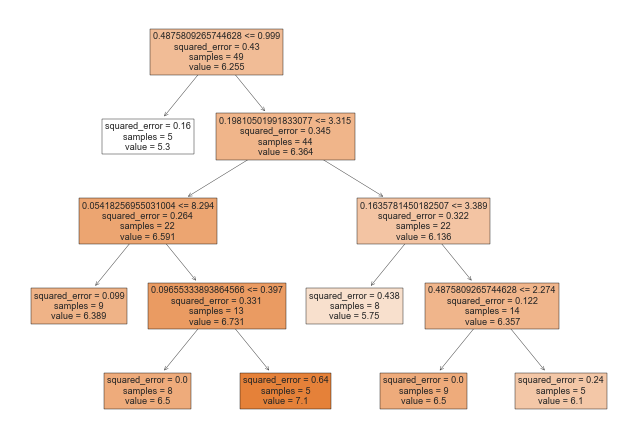

In [453]:
plot_tree(model, feature_names=model.feature_importances_, class_names=model.feature_importances_, filled=True);

In [316]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import r2_score, mean_squared_error

In [298]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [305]:
model.score(X_test, y_test)

0.18111229321867295

In [326]:
cross_validate(model, X, y, cv=KFold())

{'fit_time': array([0.0035398 , 0.        , 0.00292635, 0.00297213, 0.        ]),
 'score_time': array([0.00125837, 0.00261474, 0.00185513, 0.        , 0.00709796]),
 'test_score': array([-0.31693133, -0.59647856, -0.27206671, -2.39074776,  0.03280447])}

In [328]:
from pycaret.regression import *

In [333]:
exp = setup(data=X, target=y.reshape(-1))

,Description,Value
0,Session id,2193
1,Target,target
2,Target type,Regression
3,Original data shape,"(49, 7)"
4,Transformed data shape,"(49, 7)"
5,Transformed train set shape,"(34, 7)"
6,Transformed test set shape,"(15, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


C:\Users\Thabang Ndhlovu\AppData\Roaming\Python\Python311\site-packages\pycaret\internal\metrics.py:51: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [334]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,0.4403,0.4434,0.5860,-0.2408,0.0825,0.0744,0.0240
lasso,Lasso Regression,0.4747,0.4848,0.6100,-0.3119,0.0859,0.0806,0.0320
llar,Lasso Least Angle Regression,0.4747,0.4848,0.6100,-0.3119,0.0859,0.0806,0.0380
dummy,Dummy Regressor,0.5454,0.5343,0.6495,-0.4381,0.0914,0.0919,0.0340
lightgbm,Light Gradient Boosting Machine,0.5454,0.5343,0.6495,-0.4381,0.0914,0.0919,0.0570
br,Bayesian Ridge,0.5602,0.5536,0.6649,-0.4406,0.0933,0.0942,0.0370
omp,Orthogonal Matching Pursuit,0.5523,0.5371,0.6573,-0.4513,0.0922,0.0927,0.0340
catboost,CatBoost Regressor,0.5926,0.5878,0.6897,-0.4954,0.0967,0.0988,0.8350
rf,Random Forest Regressor,0.5897,0.6102,0.7051,-0.5164,0.0985,0.0975,0.1380
knn,K Neighbors Regressor,0.5367,0.6287,0.7083,-0.7327,0.0993,0.0893,0.0340


C:\Users\Thabang Ndhlovu\AppData\Roaming\Python\Python311\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


In [302]:
import numpy as np
from sklearn.linear_model import Ridge

# Assuming X and y are your features and target variable respectively
model = Ridge().fit(X_train, y_train)

# Original coefficients
coef_ = model.coef_

# Rescale coefficients so they sum to 1
weights = coef_ / np.sum(coef_)

# Now you can use weights for a linear combination of features
X @ weights.T

array([[  0.55522891],
       [ 14.89190173],
       [ -1.58309371],
       [  3.32465314],
       [ 38.68652249],
       [  5.52015254],
       [ 32.34436391],
       [ 16.17162997],
       [  7.68555684],
       [ -4.22811411],
       [ 16.44003457],
       [ 13.54071598],
       [-12.02633739],
       [  0.40789907],
       [-20.48159535],
       [ -7.25465455],
       [-11.59807886],
       [-53.4122505 ],
       [  3.59378156],
       [  9.19322037],
       [ -9.96076898],
       [  4.27161374],
       [ -7.45611766],
       [ -7.45611766],
       [ -8.44505861],
       [ -5.96348859],
       [ 23.63189636],
       [ 10.92434567],
       [ -9.4766129 ],
       [ -7.35956356],
       [ -5.36156283],
       [-12.70632737],
       [-10.50421169],
       [ 11.31372177],
       [ 11.31372177],
       [ 16.00082343],
       [ -7.16062273],
       [  7.13602407],
       [ -9.86891026],
       [ -6.4521705 ],
       [ -7.53289464],
       [  7.17705215],
       [  4.7802995 ],
       [  2

In [287]:
model.score(X, y)

0.2831515534409609

In [289]:
model.predict??

Signature: model.predict(X)
Source:   
    def predict(self, X):
        """
        Predict using the linear model.

        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            Samples.

        Returns
        -------
        C : array, shape (n_samples,)
            Returns predicted values.
        """
        return self._decision_function(X)
File:      c:\users\thabang ndhlovu\conda\lib\site-packages\sklearn\linear_model\_base.py
Type:      method

In [285]:
mean_squared_error(y, model.predict(X))

0.30811645016615097

In [286]:
model.predict(X)

array([[6.39088559],
       [5.93425348],
       [6.34487763],
       [6.32379298],
       [5.04573432],
       [6.20066477],
       [5.33513529],
       [5.92008554],
       [6.1305509 ],
       [6.41896447],
       [5.93279792],
       [6.01172055],
       [6.62325651],
       [6.40902955],
       [6.3572451 ],
       [6.5975582 ],
       [6.57235999],
       [6.74458646],
       [6.3401803 ],
       [6.08022906],
       [6.5613697 ],
       [6.02460641],
       [6.58390802],
       [6.58390802],
       [6.48326694],
       [6.47626041],
       [5.59126265],
       [5.88107301],
       [6.52910582],
       [6.48376345],
       [6.43707567],
       [6.55804498],
       [6.52637045],
       [6.01460161],
       [6.01460161],
       [5.79943251],
       [6.56897083],
       [6.29990175],
       [6.53927055],
       [6.51991434],
       [6.48973864],
       [6.13785486],
       [6.21587599],
       [6.15688478],
       [6.36754449],
       [6.45957775],
       [5.67238627],
       [6.579

In [284]:
model.coef_ @ X.T

array([[-0.15412016, -0.61075228, -0.20012812, -0.22121278, -1.49927144,
        -0.34434098, -1.20987047, -0.62492022, -0.41445486, -0.12604129,
        -0.61220784, -0.53328521,  0.07825075, -0.13597621, -0.18776066,
         0.05255244,  0.02735423,  0.1995807 , -0.20482546, -0.4647767 ,
         0.01636394, -0.52039935,  0.03890227,  0.03890227, -0.06173882,
        -0.06874535, -0.95374311, -0.66393275, -0.01589994, -0.06124231,
        -0.10793009,  0.01303922, -0.01863531, -0.53040415, -0.53040415,
        -0.74557325,  0.02396507, -0.24510401, -0.00573521, -0.02509142,
        -0.05526712, -0.4071509 , -0.32912977, -0.38812097, -0.17746127,
        -0.085428  , -0.87261949,  0.03466259, -0.31515421]])

In [146]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

In [269]:
import numpy as np
from scipy.optimize import minimize

def optimize_weights(X, y):
    
    def error_function(weights):
        predicted_y = np.dot(X, weights)
        error = np.mean((predicted_y - y) ** 2)  # Mean Squared Error
        return mean_squared_error(y, predicted_y)
    
    bounds = [(None, 1)] * X.shape[1]
    constraint = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    result = minimize(error_function, np.ones(X.shape[1]), method="SLSQP", bounds=bounds, constraints=constraint)

    # Extract the optimal weights
    optimal_weights = result.x
    print(result)
    return optimal_weights

# Obtain optimal weights
optimal_weights = optimize_weights(X, y)
print("Optimal weights:", optimal_weights)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.683299637112679
       x: [ 9.824e-02 -4.840e-04  6.219e-01  2.452e-01 -8.937e-02
            1.245e-01]
     nit: 14
     jac: [-2.619e+00 -2.536e+00 -2.618e+00 -2.618e+00 -2.619e+00
           -2.619e+00]
    nfev: 102
    njev: 14
Optimal weights: [ 9.82440729e-02 -4.84034390e-04  6.21891961e-01  2.45248343e-01
 -8.93738170e-02  1.24473475e-01]


In [270]:
optimal_weights

array([ 9.82440729e-02, -4.84034390e-04,  6.21891961e-01,  2.45248343e-01,
       -8.93738170e-02,  1.24473475e-01])

In [171]:
a = optimal_weights[4:]
print(a.sum())
a /= a.sum()
print(a)

-0.3148423265868361
[0.27923243 0.72076757]


In [172]:
a

array([0.27923243, 0.72076757])

In [226]:
X = np.where(np.nan == X, X, 0)

In [242]:
import numpy as np
from IPython.display import clear_output
def compute_error(X, y, w):
    y_pred = np.dot(X, w)
    error = np.mean((y_pred - y) ** 2)
    print(error)
    clear_output(wait=True)
    return mean_squared_error(y, y_pred)

def gradient_descent(X, y, learning_rate=0.0083, epochs=10000):
    num_features = X.shape[1]
    w = np.random.randn(num_features) # initialize weights randomly
    for _ in range(epochs):
        y_pred = np.dot(X, w)
        error = compute_error(X, y, w)
        gradient = 2 * np.dot(X.T, (y_pred - y)) / len(y)
        w -= learning_rate * gradient
    return w

# Example usage:
# X is the feature matrix, y is the target vector
# Make sure X has shape (num_samples, num_features) and y has shape (num_samples,)
# Call gradient_descent function to get optimized weights

In [243]:
optimized_weights = gradient_descent(X, y_true)


39.55612244897959


In [244]:
optimized_weights

array([ 0.45392636,  0.4881422 , -0.79690722, -1.27179793,  0.15143154,
        1.25591873])

In [354]:
def compute_credit_score(oper_margin, tot_debt_to_tot_eqy, tot_debt_to_ebitda, ebitda_to_tot_int_exp, return_on_asset, asset_turnover):
    metrics = [oper_margin, 1 - tot_debt_to_tot_eqy, 1 - tot_debt_to_ebitda, ebitda_to_tot_int_exp, return_on_asset, asset_turnover]
    weights = [0.20, 0.20, 0.20, 0.15, 0.15, 0.10]  # Weights for each metric

    score = sum(m * w for m, w in zip(metrics, weights)) * 7.5 + 2.5
    score = min(max(score, 2.5), 8.5)

    ratings = ["Aaa", "Aa", "A", "Baa", "Ba", "B", "Caa", "Ca", "C"]
    rating_index = max(int(score - 2.5), 0)  
    return score, ratings[rating_index]

# Example usage
credit_score, credit_rating = compute_credit_score(0.8, 0.4, 0.3, 0.7, 0.5, 0.6)
print(f"Credit Score: {credit_score:.2f}, Credit Rating: {credit_rating}")


Credit Score: 7.45, Credit Rating: Ba


In [356]:
ratios

{'oper_margin': 4.372,
 'tot_debt_to_tot_eqy': 98.646,
 'tot_debt_to_ebitda': 2.0211,
 'ebitda_to_tot_int_exp': 5.5277,
 'return_on_asset': 11.2683,
 'asset_turnover': 3.8526}

In [364]:
settings = {
    "categories": {
        "profitability": {"weight": 0.3, "metrics": {"oper_margin": {"weight": 1.0, "lower_is_better": False}}},
        "leverage_coverage": {"weight": 0.4, "metrics": {
            "tot_debt_to_tot_eqy": {"weight": 0.35, "lower_is_better": True},
            "tot_debt_to_ebitda": {"weight": 0.35, "lower_is_better": True},
            "ebitda_to_tot_int_exp": {"weight": 0.30, "lower_is_better": False}
        }},
        "efficiency": {"weight": 0.3, "metrics": {
            "return_on_asset": {"weight": 0.60, "lower_is_better": False},
            "asset_turnover": {"weight": 0.40, "lower_is_better": False}
        }}
    }
}


In [366]:
def compute_credit_score(settings, **metrics):
    overall_score = sum(
        cat_details["weight"] * sum(
            (1 - metrics[metric] if detail["lower_is_better"] else metrics[metric]) * detail["weight"]
            for metric, detail in cat_details["metrics"].items()
        )
        for category, cat_details in settings["categories"].items()
    )

    # Scale and bound the score within the rating scale
    overall_score = min(max(overall_score * 7.5 + 2.5, 2.5), 8.5)

    # Map score to rating
    ratings = ["Aaa", "Aa", "A", "Baa", "Ba", "B", "Caa", "Ca", "C"]
    rating_index = max(int(overall_score - 2.5), 0)
    return overall_score, ratings[rating_index]

# Example usage
credit_score, credit_rating = compute_credit_score(
    settings,
    **ratios,
    # oper_margin=0.8,
    # tot_debt_to_tot_eqy=0.4,
    # tot_debt_to_ebitda=0.3,
    # ebitda_to_tot_int_exp=0.7,
    # return_on_asset=0.5,
    # asset_turnover=0.6
)
print(f"Credit Score: {credit_score:.2f}, Credit Rating: {credit_rating}")


Credit Score: 2.50, Credit Rating: Aaa
